In [2]:
## Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [4]:
## Spread Data
df = pd.read_csv('data/spreadspoke_scores.csv')

## NFL team name data
nfl_teams = pd.read_csv('data/nfl_teams.csv')

df = df.merge(nfl_teams, left_on='team_favorite_id', right_on='team_id', how='left')

df = df.rename(columns={'team_name': 'team_favorite'})

## Limit to >=2000
df = df[df['schedule_season'].between(2000, 2024)]

## Determine Winner
df['team_winner'] = np.where(df['score_home'] > df['score_away'], df['team_home'], df['team_away'])

## Determine Score of Favored Team
df['score_favorite'] = np.where(df['team_favorite'] == df['team_home'], df['score_home'], df['score_away'])

## Score of Underdog Team
df['score_underdog'] = np.where(df['team_favorite'] != df['team_home'], df['score_home'], df['score_away'])

## Result of Favorite Team (to determine cover)
df['favorite_margin'] = df['score_favorite'] - df['score_underdog']

## Cover
df['cover'] = df['favorite_margin'] > df['spread_favorite'].abs()

## nfl_teams has multiple team names for the same id. This is a hacky way around that
df = df[(df['team_favorite'] == df['team_home']) | (df['team_favorite'] == df['team_away'])]

df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002,team_winner,score_favorite,score_underdog,favorite_margin,cover
9249,9/3/2000,2000,1,False,Atlanta Falcons,36.0,28.0,San Francisco 49ers,ATL,-6.5,...,ATL,NFC,NFC South,NFC,NFC West,Atlanta Falcons,36.0,28.0,8.0,True
9250,9/3/2000,2000,1,False,Buffalo Bills,16.0,13.0,Tennessee Titans,BUF,-1.0,...,BUF,AFC,AFC East,AFC,AFC East,Buffalo Bills,16.0,13.0,3.0,True
9251,9/3/2000,2000,1,False,Cleveland Browns,7.0,27.0,Jacksonville Jaguars,JAX,-10.5,...,JAX,AFC,AFC South,AFC,AFC Central,Jacksonville Jaguars,27.0,7.0,20.0,True
9252,9/3/2000,2000,1,False,Dallas Cowboys,14.0,41.0,Philadelphia Eagles,DAL,-6.0,...,DAL,NFC,NFC East,NFC,NFC East,Philadelphia Eagles,14.0,41.0,-27.0,False
9253,9/3/2000,2000,1,False,Green Bay Packers,16.0,20.0,New York Jets,GB,-2.5,...,GNB,NFC,NFC North,NFC,NFC Central,New York Jets,16.0,20.0,-4.0,False


In [5]:
## Select cols of interest

cols = ['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'team_favorite', 'team_id',
       'team_winner', 'score_favorite', 'score_underdog', 'favorite_margin', 'cover']

df = df[cols]

df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,team_favorite,team_id,team_winner,score_favorite,score_underdog,favorite_margin,cover
9249,9/3/2000,2000,1,False,Atlanta Falcons,36.0,28.0,San Francisco 49ers,ATL,-6.5,Atlanta Falcons,ATL,Atlanta Falcons,36.0,28.0,8.0,True
9250,9/3/2000,2000,1,False,Buffalo Bills,16.0,13.0,Tennessee Titans,BUF,-1.0,Buffalo Bills,BUF,Buffalo Bills,16.0,13.0,3.0,True
9251,9/3/2000,2000,1,False,Cleveland Browns,7.0,27.0,Jacksonville Jaguars,JAX,-10.5,Jacksonville Jaguars,JAX,Jacksonville Jaguars,27.0,7.0,20.0,True
9252,9/3/2000,2000,1,False,Dallas Cowboys,14.0,41.0,Philadelphia Eagles,DAL,-6.0,Dallas Cowboys,DAL,Philadelphia Eagles,14.0,41.0,-27.0,False
9253,9/3/2000,2000,1,False,Green Bay Packers,16.0,20.0,New York Jets,GB,-2.5,Green Bay Packers,GB,New York Jets,16.0,20.0,-4.0,False


In [6]:
## Limit to playoff games

playoff_df = df[df['schedule_playoff']]

bye_by_season = {}

## Determine which teams had a bye, if you played in Division but NOT wildcard, you had a bye

for season, group in playoff_df.groupby('schedule_season'):
    wc = group[group['schedule_week'] == 'Wildcard']
    div = group[group['schedule_week'] == 'Division']

    wc_teams = set(wc['team_home']).union(wc['team_away'])
    div_teams = set(div['team_home']).union(div['team_away'])

    bye_by_season[season] = sorted(div_teams - wc_teams)

## df for bye teams

bye_df = (
    pd.DataFrame([
        {'schedule_season': season, 'team': team}
        for season, teams in bye_by_season.items()
        for team in teams
    ])
    .assign(had_bye=True)
)

bye_df.head()


,schedule_season,team,had_bye
0,2000,Minnesota Vikings,True
1,2000,New York Giants,True
2,2000,Oakland Raiders,True
3,2000,Tennessee Titans,True
4,2001,Chicago Bears,True


In [7]:
## join byes df back to playoff df

final_df = playoff_df.merge(bye_df, left_on=['schedule_season', 'team_home'], right_on = ['schedule_season', 'team'], how='left')

final_df['had_bye'] = final_df['had_bye'].fillna(0).astype('bool')

## limit to divisional round (first game after bye)

final_df = final_df[(final_df['schedule_week'] == 'Division') & (final_df['had_bye'])]

final_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,team_favorite,team_id,team_winner,score_favorite,score_underdog,favorite_margin,cover,team,had_bye
4,1/6/2001,2000,Division,True,Minnesota Vikings,34.0,16.0,New Orleans Saints,MIN,-8.0,Minnesota Vikings,MIN,Minnesota Vikings,34.0,16.0,18.0,True,Minnesota Vikings,True
5,1/6/2001,2000,Division,True,Oakland Raiders,27.0,0.0,Miami Dolphins,LVR,-9.0,Oakland Raiders,LVR,Oakland Raiders,27.0,0.0,27.0,True,Oakland Raiders,True
6,1/7/2001,2000,Division,True,New York Giants,20.0,10.0,Philadelphia Eagles,NYG,-4.5,New York Giants,NYG,New York Giants,20.0,10.0,10.0,True,New York Giants,True
7,1/7/2001,2000,Division,True,Tennessee Titans,10.0,24.0,Baltimore Ravens,TEN,-6.0,Tennessee Titans,TEN,Baltimore Ravens,10.0,24.0,-14.0,False,Tennessee Titans,True
15,1/19/2002,2001,Division,True,Chicago Bears,19.0,33.0,Philadelphia Eagles,CHI,-3.0,Chicago Bears,CHI,Philadelphia Eagles,19.0,33.0,-14.0,False,Chicago Bears,True


/var/folders/48/7j0dyypd3k15l8317cddgxy40000gn/T/ipykernel_4358/899120900.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bye_wins_df, x='won', y='percentage', palette='muted')


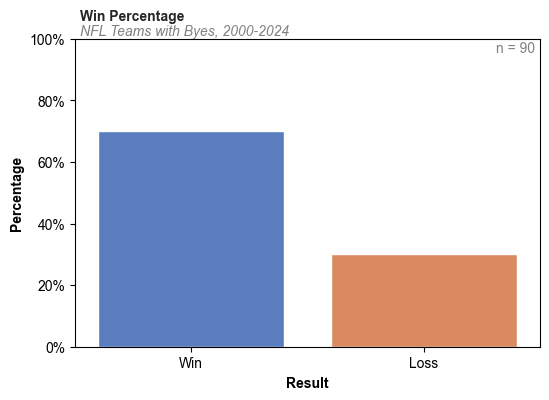

In [8]:
## When a team has a bye, how often do they win their first game?

fig, ax = plt.subplots(figsize=(6,4))

bye_wins = (final_df['team_home'] == final_df['team_winner']).value_counts(normalize=True)

bye_wins_df = bye_wins.rename_axis('won').reset_index(name='percentage')
bye_wins_df['won'] = bye_wins_df['won'].map({True: 'Win', False: 'Loss'})

sns.set_style("darkgrid")

sns.barplot(data=bye_wins_df, x='won', y='percentage', palette='muted')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Percentage', fontweight='bold')
plt.xlabel('Result', fontweight='bold')

ax.text(
    0.01, 1.05, "Win Percentage", transform=ax.transAxes, fontweight="bold", ha="left", va="bottom", clip_on=False
)

ax.text(
    0.01, 1.00, "NFL Teams with Byes, 2000-2024", transform=ax.transAxes, ha="left", va="bottom", fontsize=10, color="gray", fontstyle='italic', clip_on=False
)

ax.text(
    0.99, 0.99, "n = 90", transform=ax.transAxes, ha="right", va="top", fontsize=10, color="gray", clip_on=False
)

plt.ylim(0,1)
plt.show()

/var/folders/48/7j0dyypd3k15l8317cddgxy40000gn/T/ipykernel_4358/1828137080.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bye_covers_df[::-1], x='won', y='percentage', palette='muted')


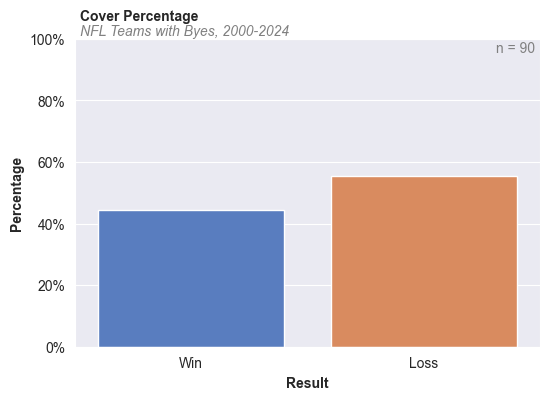

In [9]:
## When a team has a bye, how often do they cover their first game?

fig, ax = plt.subplots(figsize=(6,4))

bye_covers = (final_df['cover']).value_counts(normalize=True)

bye_covers_df = bye_covers.rename_axis('won').reset_index(name='percentage')
bye_covers_df['won'] = bye_covers_df['won'].map({True: 'Win', False: 'Loss'})

sns.set_style("darkgrid")

sns.barplot(data=bye_covers_df[::-1], x='won', y='percentage', palette='muted')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('Percentage', fontweight='bold')
plt.xlabel('Result', fontweight='bold')

ax.text(
    0.01, 1.05, "Cover Percentage", transform=ax.transAxes, fontweight="bold", ha="left", va="bottom", clip_on=False
)

ax.text(
    0.01, 1.00, "NFL Teams with Byes, 2000-2024", transform=ax.transAxes, ha="left", va="bottom", fontsize=10, color="gray", fontstyle='italic', clip_on=False
)

ax.text(
    0.99, 0.99, "n = 90", transform=ax.transAxes, ha="right", va="top", fontsize=10, color="gray", clip_on=False
)

plt.ylim(0,1)
plt.show()

In [10]:
## Determine percent chance a team wins based on spread from regular season games

regular_season_df = df[~df['schedule_playoff']]

regular_season_df['favorite_won'] = regular_season_df['team_favorite'] == regular_season_df['team_winner']

pct_won = regular_season_df.groupby('spread_favorite').agg(
    pct_won=("favorite_won", lambda x: x.mean()),
    count=("favorite_won", "size")
).reset_index()

pct_won.tail()

/var/folders/48/7j0dyypd3k15l8317cddgxy40000gn/T/ipykernel_4358/1346970427.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_season_df['favorite_won'] = regular_season_df['team_favorite'] == regular_season_df['team_winner']


,spread_favorite,pct_won,count
40,-3.0,0.574487,1121
41,-2.5,0.560440,455
42,-2.0,0.545455,231
43,-1.5,0.562212,217
44,-1.0,0.489426,331


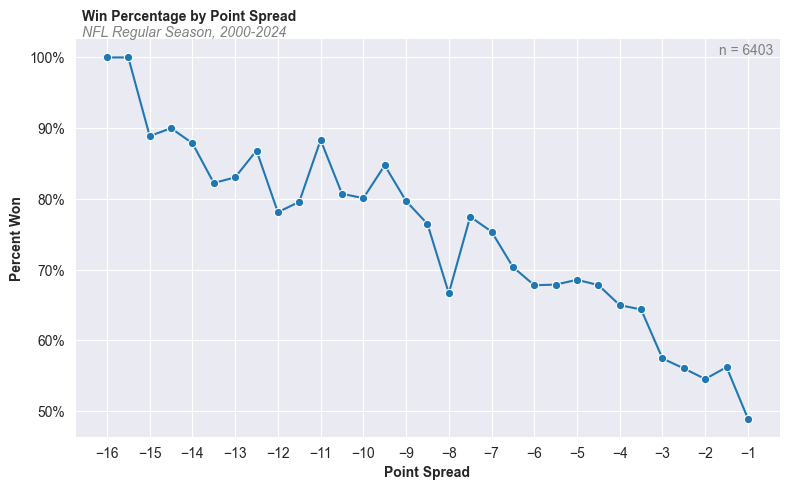

In [11]:
## How often does the favorite win based on the point spread?

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(
    data=pct_won[pct_won['spread_favorite'] >= -16],
    x="spread_favorite", y="pct_won",
    marker="o", ax=ax
)

ax.set_xticks(range(-16, 0, 1))
ax.set_xlabel("Point Spread", fontweight="bold")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel("Percent Won", fontweight="bold")

ax.text(
    0.01, 1.04, "Win Percentage by Point Spread", transform=ax.transAxes, fontweight="bold", ha="left", va="bottom", clip_on=False
)

ax.text(
    0.01, 1.00, "NFL Regular Season, 2000-2024", transform=ax.transAxes, ha="left", va="bottom", fontsize=10, color="gray", fontstyle='italic', clip_on=False
)

ax.text(
    0.99, 0.99, "n = 6403", transform=ax.transAxes, ha="right", va="top", fontsize=10, color="gray", clip_on=False
)

sns.despine()
fig.tight_layout()
plt.show()


In [ ]:
## Join percent chance to win back to playoff df

with_pct = playoff_df.merge(pct_won, on='spread_favorite', how='left')

with_pct.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,team_favorite,team_id,team_winner,score_favorite,score_underdog,favorite_margin,cover,pct_won,count
0,12/30/2000,2000,Wildcard,True,Miami Dolphins,23.0,17.0,Indianapolis Colts,IND,-1.5,Indianapolis Colts,IND,Miami Dolphins,17.0,23.0,-6.0,False,0.562212,217
1,12/30/2000,2000,Wildcard,True,New Orleans Saints,31.0,28.0,St. Louis Rams,LAR,-5.5,St. Louis Rams,LAR,New Orleans Saints,28.0,31.0,-3.0,False,0.678899,218
2,12/31/2000,2000,Wildcard,True,Baltimore Ravens,21.0,3.0,Denver Broncos,BAL,-3.5,Baltimore Ravens,BAL,Baltimore Ravens,21.0,3.0,18.0,True,0.643810,525
3,12/31/2000,2000,Wildcard,True,Philadelphia Eagles,21.0,3.0,Tampa Bay Buccaneers,TB,-3.0,Tampa Bay Buccaneers,TB,Philadelphia Eagles,3.0,21.0,-18.0,False,0.574487,1121
4,1/6/2001,2000,Division,True,Minnesota Vikings,34.0,16.0,New Orleans Saints,MIN,-8.0,Minnesota Vikings,MIN,Minnesota Vikings,34.0,16.0,18.0,True,0.666667,117


In [14]:
## Simulate 90 game sample N times and record win totals

n_simulations = 10000

win_totals = []

for _ in range(0, n_simulations):
    print(f"Simulation {_+1}/{n_simulations}", end="\r")
    wins = 0
    for _, row in with_pct.iterrows():
        if row['pct_won'] > np.random.uniform(0, 1):
            wins += 1
    win_totals.append(wins)

Text(0, 0.5, 'Count')

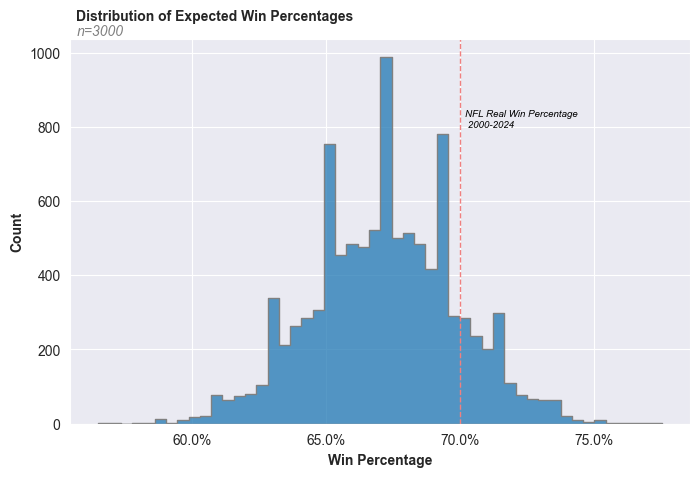

In [15]:
## Distrubution of simulated win percetages

win_percentages = [wins / len(playoff_df) for wins in win_totals]

sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,5))

sns.histplot(win_percentages, bins=50, edgecolor='gray', element='step') 

plt.axvline(x=0.7, color='lightcoral', linestyle='dashed', linewidth=1)

ax.text(
    0.01, 1.04, "Distribution of Expected Win Percentages", transform=ax.transAxes, fontweight="bold", ha="left", va="bottom", clip_on=False
)

ax.text(
    0.01, 1.00, "n=3000", transform=ax.transAxes, ha="left", va="bottom", fontsize=10, color="gray", fontstyle='italic', clip_on=False
)

ax.text(
    0.702, 800, "NFL Real Win Percentage \n 2000-2024", color="black", fontstyle='italic', fontsize=7
)

ax.set_xlabel("Win Percentage", fontweight="bold")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel("Count", fontweight="bold")